#  Deep Learning Project: Mini Image classification Competition with CNN


### Environment
Python 3, Numpy, matplotlib, torch, torchvision...

### Dataset
We download 45,000 images and corresponding labels. <br>
W

#### Download the given dataset

In [14]:
# import necessary packages
import os, time
import torch 
#!pip install requests
import requests, zipfile, sys
import numpy as np
import matplotlib.pyplot as plt 
from torch.utils.data import Dataset, DataLoader
from utils import download_given_data, get_preds_figure
import torchvision
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, utils
import random, matplotlib
#!pip install pandas
import pandas as pd
#!pip install tb-nightly
from torchvision.models.resnet import BasicBlock
from torch.utils.tensorboard import SummaryWriter

download_given_data('./')

Data was already downloaded and extracted!


In [15]:
class FashionMNISTDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        # Read the csv file
        self.frame = pd.read_csv(csv_file, header=None)
        self.transform = transform
        
        self.label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    def __getitem__(self, idx):
        image_name = self.frame.iloc[idx, 0]
        image = Image.open(image_name)
        
        label = self.frame.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
            
        sample = {'image': image, 'label': label}

        return sample

    def __len__(self):
        return len(self.frame)

Build our custom data augmentation

In [16]:
class RandomWindowDrop(object):
    def __init__(self, window_size):
        assert isinstance(window_size, (int, tuple))
        if isinstance(window_size, int):
            self.window_size = (window_size, window_size)
        else:
            assert len(window_size) == 2
            self.window_size = window_size
        
        # Define a horizontalFlip
        self.trans = transforms.RandomHorizontalFlip(p=1.0)

    def __call__(self, sample):
        image = sample

        # Perform either RandomWindowDrop or RandomHorizontalFlip
        if random.random() < 0.5:
            h, w = image.size
            imagePixels = image.load()
            top = np.random.randint(self.window_size[0], h - self.window_size[0])
            left = np.random.randint(self.window_size[1], w - self.window_size[1])
            for i in range(top, top+self.window_size[0], 1):
                for j in range(left, left+self.window_size[1], 1):   
                    imagePixels[i, j] = 0
        else:
            image = self.trans(image)

        return image

 Load the training/validation/testing data to Dataloader

In [17]:
def getTrainingData(csv_file='', batch_size=64, num_workers=0):
    __normalize_stats = {'mean': [0.5], 'std': [0.5]}

    # transforms.Compose create a list of transformations
    transformed_training = FashionMNISTDataset(csv_file=csv_file,
                                        transform=transforms.Compose([
                                            transforms.Resize(224),                          
                                            transforms.RandomHorizontalFlip(),                          
                                            transforms.ToTensor(),
                                            transforms.Normalize(__normalize_stats['mean'],
                                                      __normalize_stats['std'])
                                        ]))

    dataloader_training = DataLoader(transformed_training, batch_size, shuffle=True, num_workers=num_workers)

    return dataloader_training


def getEvalData(csv_file='', batch_size=64, num_workers=0):
    __normalize_stats = {'mean': [0.5], 'std': [0.5]}
    # TODO: Part 1.4 (1 point)
    transformed_eval = FashionMNISTDataset(csv_file=csv_file,
                                        transform=transforms.Compose([
                                        transforms.Resize(224),                          
                                        transforms.ToTensor(),
                                        transforms.Normalize(__normalize_stats['mean'],
                                                      __normalize_stats['std'])
                                        ]))
    
    # DataLoader shuffle=False
    dataloader_eval = DataLoader(transformed_eval, batch_size, shuffle=False, num_workers=num_workers)

    return dataloader_eval
    
def getTestData(csv_file='', batch_size=64, num_workers=0):
    __normalize_stats = {'mean': [0.5], 'std': [0.5]}
    # TODO: Part 1.4 (1 point)
    transformed_test = FashionMNISTDataset(csv_file=csv_file,
                                        transform=transforms.Compose([
                                            transforms.Resize(224),                          
                                            transforms.ToTensor(),
                                            transforms.Normalize(__normalize_stats['mean'],
                                                      __normalize_stats['std'])
                                        ]))
    
    # DataLoader shuffle=False
    dataloader_test = DataLoader(transformed_test, batch_size, shuffle=False, num_workers=num_workers)

    return dataloader_test


 create our training/validation DataLoaders

In [0]:
#/content/given_data/train.csv

In [18]:
# Set batch_size to 64, shuffling the training set and use 2 workers to do parallel reading.
train_loader = getTrainingData(csv_file='./given_data/train.csv', batch_size=64, num_workers=0)

# batch_size = 64
valid_loader = getEvalData(csv_file='./given_data/val.csv', batch_size=64, num_workers=0)



Build a CNN

In [19]:
class Network(nn.Module):
    def __init__(self, num_classes):
        super().__init__() 

        # define layers 
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(6)
        self.relu1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # TODO: fill the rest part (0.5 points)  
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3,padding=1)
        self.bn2=nn.BatchNorm2d(12)
        self.fc1 = nn.Linear(in_features=768, out_features=350)
        self.fc2 = nn.Linear(in_features=350, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)    

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)     
        x = self.max_pool1(x) 
        # TODO: fill the rest part, you may need more lines like x = ... (0.5 points)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu1(x)
        x = self.max_pool1(x)
        x = x.reshape(x.shape[0], -1)
        #print("the shape here is,",x.shape[0]) 
        x = self.fc1(x)
        x= self.relu1(x)
        x = self.fc2(x)
        x= self.relu1(x)
        x =self.fc3(x)
        x= self.relu1(x)
        x = self.out(x)
        return x
    

ResNet18

In [20]:
class ResNet18_Fashion_MNIST(torchvision.models.ResNet):
    def __init__(self, num_classes=10):
        super(ResNet18_Fashion_MNIST, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)
        # Override the "conv1" layer from the resnet-18 model
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    def forward(self, x):
        return super(ResNet18_Fashion_MNIST, self).forward(x)

Train and validate  

ResNet18_Fashion_MNIST(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(

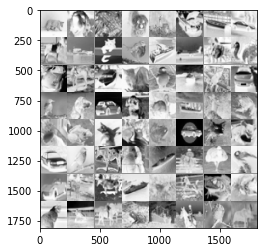

In [21]:

# tensorboard --logdir tb_graphs/ --port 5656
writer = SummaryWriter('tb_graphs/training')
val_writer = SummaryWriter('tb_graphs/validation')

# Switch between models

#net = Network(num_classes=10)
net = ResNet18_Fashion_MNIST(num_classes=10)

    
# Print out the layers of our model
print(net)

# Get some random training images
_iter = iter(train_loader)
samples = _iter.next()
images = samples['image']

# Create grid of images
img_grid = torchvision.utils.make_grid(images)

# Show images
plt.imshow(img_grid.mean(dim=0).cpu().numpy(), cmap="Greys")

# Write to tensorboard
writer.add_image('train_images', img_grid)

# Write model graph to tensorboard
writer.add_graph(net, images)

Training and tensorbord

In [25]:
def eval(net, loss_function, data_loader):
    net.cuda()
    net.eval()
    correct = 0.0
    num_images = 0.0
    running_loss = 0.0
    for i, sample in enumerate(data_loader):
        # TODO: fill these blanks
        images, labels = sample['image'], sample['label']
        images = images.cuda()
        labels = labels.cuda()
        outs =  net(images)
        _, preds = outs.max(1)
        correct += preds.eq(labels).sum()
        running_loss += loss_function(outs, labels).item()
        num_images += len(labels)

    acc = correct.float() / num_images
    loss = running_loss / len(data_loader)
    return acc, loss

# training function
def train(net, train_loader, valid_loader, writer, val_writer, loss_function):
    # TODO: build your SGD optimizer with learning rate=0.01, momentum=0.9, no weight decay
    #optimizer = optim.SGD(net.parameters(),lr=0.01,momentum=0.9,weight_decay=0) 
    optimizer=optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    # Log training process to tensorboard every 100 iterations
    log_every = 100
    # Training for 20 epochs (you can modify this)
    epoches = 20
    for epoch in range(epoches):
        start_t = time.time()
        net.cuda()
        net.train() 
        running_loss = 0.0
        running_acc = 0.0
        for i, sample in enumerate(train_loader):
            # TODO: fill these blanks 
            images, labels = sample['image'], sample['label']  
            images = images.cuda()
            labels = labels.cuda()         
            outs = net(images)
            loss = loss_function(outs, labels) 
            _, preds = outs.max(1)
            correct = preds.eq(labels).sum()
            running_acc += correct.float() / len(labels)
            # TODO: clear grads, back-propagation, backward propogation, update parameters
            #clearing the grad 
            optimizer.zero_grad()  
            #backward propagation
            loss.backward() 
            #update parameters
            optimizer.step()
                        
            running_loss += loss.item()
            
            
            if i % log_every == 99: 
                
                print('[Epoch/iter]: [{}/{}], loss: {:.05f}, accuracy: {:.05f}'.format(epoch, i+1, 
                           running_loss / log_every, running_acc / log_every))

                log_index = epoch * len(train_loader) + i
                # Log the training loss and accuracy
                # Example of using .add_scalar()
                # Note tag='Loss'
                writer.add_scalar('Loss', running_loss / log_every, log_index) # tag='Loss'
                # TODO: load the training accuracy using writer (0.5 points)
                # Note tag='Accuracy'
                writer.add_scalar('Accuracy',running_acc / log_every, log_index)
                

                # Log predictions
                # Example of using .add_figure()
                writer.add_figure('predictions', get_preds_figure(net, images, labels), log_index)
                running_loss = 0.0
                running_acc = 0.0

        
        # Running the validation
        acc_eval, loss_eval = eval(net, loss_function, valid_loader)
        print('Elapsed time: {:.02f} seconds, end of epoch: {}, lr: {}, val_loss: {:.05f}, val_acc: {:.05f}'.format(
            time.time()-start_t, epoch, optimizer.param_groups[0]['lr'], loss_eval, acc_eval))
        # Log the validation loss and accuracy
        # Using val_writer will log the values to the validation writer
        # Note tag='Loss'
        val_writer.add_scalar('Loss',loss_eval/ log_every, log_index)
        # Note tag='Accuracy'
        val_writer.add_scalar('Accuracy',acc_eval/ log_every, log_index)

    return net

In [0]:
# here is the performance of the simple CNN model 

print('Please wait patiently, it may take some seconds...')
loss_function = torch.nn.CrossEntropyLoss()
mytrain=train(net, train_loader, valid_loader, writer, val_writer, loss_function)
# Save the weight of current model to disk
#PATH = './net.pth'
#torch.save(net.state_dict(), PATH)
# Load the model weights from './net.pth'
#net.load_state_dict(torch.load('./net.pth'))
# TODO: test your network here on testing data (0.5 points)
#acc_test, lossy= eval(net, loss_function, test_loader)
#print('Accuracy on testing data: {:.05f}'.format(acc_test))
# Close the training and validation writer
writer.close()
val_writer.close()

Please wait patiently, it may take some seconds...
[Epoch/iter]: [0/100], loss: 1.90407, accuracy: 0.29469
[Epoch/iter]: [0/200], loss: 1.56884, accuracy: 0.42531
[Epoch/iter]: [0/300], loss: 1.46346, accuracy: 0.47125
[Epoch/iter]: [0/400], loss: 1.41369, accuracy: 0.49078
[Epoch/iter]: [0/500], loss: 1.37743, accuracy: 0.50063
Elapsed time: 40.12 seconds, end of epoch: 0, lr: 0.001, val_loss: 1.29625, val_acc: 0.54011
[Epoch/iter]: [1/100], loss: 1.25560, accuracy: 0.54469
[Epoch/iter]: [1/200], loss: 1.23918, accuracy: 0.55406
[Epoch/iter]: [1/300], loss: 1.23621, accuracy: 0.55750
[Epoch/iter]: [1/400], loss: 1.18876, accuracy: 0.57219
[Epoch/iter]: [1/500], loss: 1.18055, accuracy: 0.58281
Elapsed time: 40.69 seconds, end of epoch: 1, lr: 0.001, val_loss: 1.19321, val_acc: 0.57133
[Epoch/iter]: [2/100], loss: 1.10387, accuracy: 0.61547
[Epoch/iter]: [2/200], loss: 1.08718, accuracy: 0.60828
[Epoch/iter]: [2/300], loss: 1.09282, accuracy: 0.61328
[Epoch/iter]: [2/400], loss: 1.0884

training the resNet

In [0]:
print('Please wait patiently, it may take some ...')
loss_function = torch.nn.CrossEntropyLoss()
mytrain=train(net, train_loader, valid_loader, writer, val_writer, loss_function)
# Save the weight of current model to disk
PATH = './net.pth'
torch.save(net.state_dict(), PATH)
# Load the model weights from './net.pth'
net.load_state_dict(torch.load('./net.pth'))
# TODO: test your network here on testing data (0.5 points)
#acc_test, lossy= eval(net, loss_function, test_loader)
#print('Accuracy on testing data: {:.05f}'.format(acc_test))
# Close the training and validation writer
writer.close()
val_writer.close()

Please wait patiently, it may take some hours...
[Epoch/iter]: [0/100], loss: 1.75144, accuracy: 0.36031
[Epoch/iter]: [0/200], loss: 1.47787, accuracy: 0.45812
[Epoch/iter]: [0/300], loss: 1.30681, accuracy: 0.52094
[Epoch/iter]: [0/400], loss: 1.23140, accuracy: 0.55875
[Epoch/iter]: [0/500], loss: 1.11897, accuracy: 0.60750
Elapsed time: 250.18 seconds, end of epoch: 0, lr: 0.001, val_loss: 1.10265, val_acc: 0.61278
[Epoch/iter]: [1/100], loss: 0.98386, accuracy: 0.65297
[Epoch/iter]: [1/200], loss: 0.93622, accuracy: 0.67281
[Epoch/iter]: [1/300], loss: 0.91458, accuracy: 0.67391
[Epoch/iter]: [1/400], loss: 0.86369, accuracy: 0.70031
[Epoch/iter]: [1/500], loss: 0.81447, accuracy: 0.70953
Elapsed time: 249.81 seconds, end of epoch: 1, lr: 0.001, val_loss: 0.89128, val_acc: 0.69167
[Epoch/iter]: [2/100], loss: 0.73959, accuracy: 0.73828
[Epoch/iter]: [2/200], loss: 0.72257, accuracy: 0.74844
[Epoch/iter]: [2/300], loss: 0.71715, accuracy: 0.74891
[Epoch/iter]: [2/400], loss: 0.6954



```
# Testing
```



In [27]:
net.load_state_dict(torch.load('./net.pth'))

<All keys matched successfully>

In [31]:
test_loader = getTestData(csv_file='./group_036_test.csv', batch_size=64, num_workers=0)

In [32]:
loss_function = torch.nn.CrossEntropyLoss()

In [33]:
def test(dataloader, model, file):
    preds = []
    model.cuda()
    model.eval()
    for i, data in enumerate(dataloader):
        images, labels = data['image'], data['label']  
        images = images.cuda()  
        output = model(images)
        output = torch.argmax(output, dim=1)
        for i in output:
            preds.append(int(i.cpu()))
    with open(file, 'w') as f:
        for i in preds:
            f.write("%s\n" % i)

In [35]:
test(test_loader, net, 'predictions0.txt')

In [3]:
torch.cuda.is_available()

True